<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

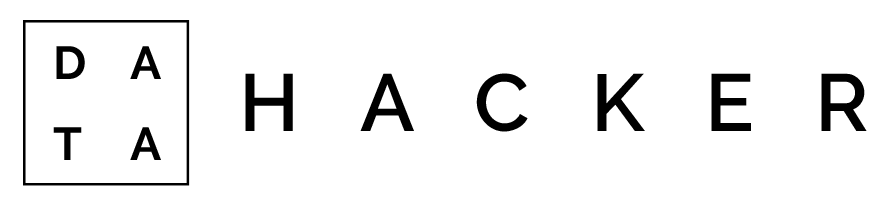
# Siamese Networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None, rand=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.rand = rand
        self.labels = iter(np.unique([file[1] for file in self.imageFolderDataset.imgs]))
        self.current_label = next(self.labels)
        self.files = iter([file[0] for file in self.imageFolderDataset.imgs if file[1]==self.current_label])
    def __getitem__(self,index):
        if self.rand:
            anchor_tuple = random.choice(self.imageFolderDataset.imgs)
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] == positive_tuple[1]:
                    break


            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break
            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
        else:
            try:
                self.current_file = next(self.files)
                while True:
                    #Look untill the same class image is found
                    positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label == positive_tuple[1]:
                        break


                while True:
                    #Look untill a different class image is found
                    negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label != negative_tuple[1]:
                        break
                anchor = Image.open(self.current_file)
                positive = Image.open(positive_tuple[0])
                negative = Image.open(negative_tuple[0])
                label = [self.current_file.split('\\')[-2]]
            except:
                self.current_label = next(self.labels)
                self.files = iter([file[0] for file in self.imageFolderDataset.imgs if file[1]==self.current_label])
                while True:
                    #Look untill the same class image is found
                    positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label == positive_tuple[1]:
                        break


                while True:
                    #Look untill a different class image is found
                    negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label != negative_tuple[1]:
                        break
                anchor = Image.open(self.current_file)
                positive = Image.open(positive_tuple[0])
                negative = Image.open(negative_tuple[0])
                label = [self.current_file.split('\\')[-2]]                

        anchor = anchor.convert("L")
        positive = positive.convert("L")
        negative = negative.convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        
        return anchor, positive, negative, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    def get_current_value(self):
        if self.index >= len(self.iterable):
            raise StopIteration
        return self.iterable[self.index]

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [4]:
#Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [5]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\training")

In [6]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

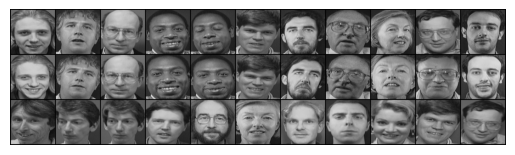

[('s12', 's15', 's13', 's22', 's22', 's33', 's11', 's34', 's32', 's31', 's16')]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=11)

# Extract one batch
example_batch = next(iter(vis_dataloader))
# Example batch is a list containing 2x8 images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=11))
print(example_batch[3])


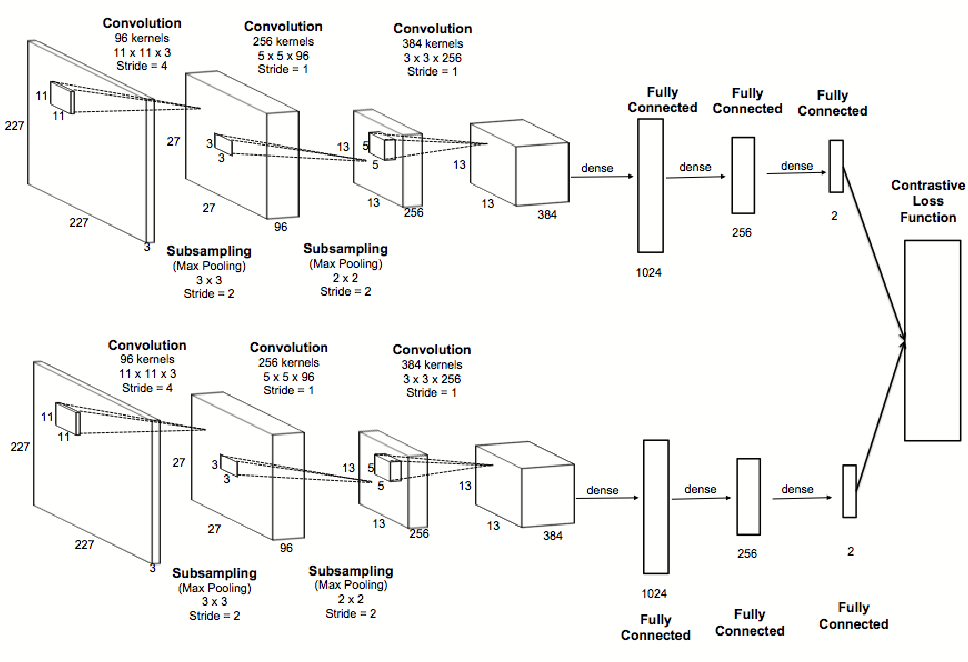

In [8]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)

        return output_anchor, output_positive, output_negative

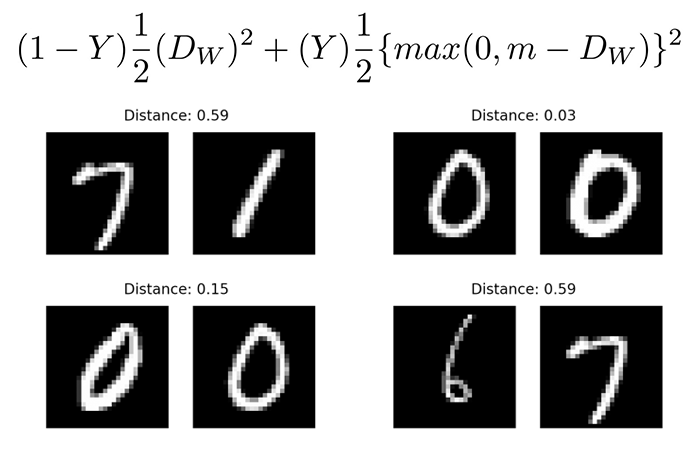

In [9]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [10]:
# Define the Triplet Loss Function
class TripletLoss(torch.nn.Module):
    def __init__(self, margin =1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        #Calculate the eucidian distance and calculate the Triplet Loss
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)

        loss_triplet = torch.mean(F.relu(distance_positive - distance_negative + self.margin))

        return loss_triplet

In [11]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=64)

In [12]:
net = SiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

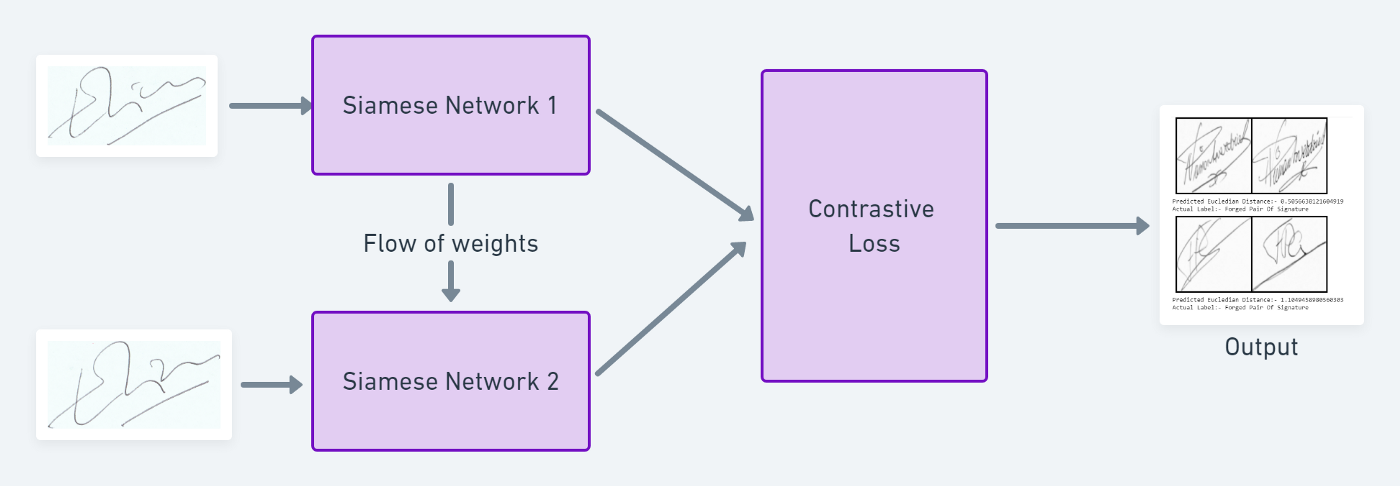

Epoch number 0
 Current loss 0.9993555545806885

Epoch number 1
 Current loss 0.7618926763534546

Epoch number 2
 Current loss 0.5508646965026855

Epoch number 3
 Current loss 0.5014980435371399

Epoch number 4
 Current loss 0.40243980288505554

Epoch number 5
 Current loss 0.30021148920059204

Epoch number 6
 Current loss 0.46864378452301025

Epoch number 7
 Current loss 0.2838507294654846

Epoch number 8
 Current loss 0.3449166417121887

Epoch number 9
 Current loss 0.24290910363197327

Epoch number 10
 Current loss 0.40197625756263733

Epoch number 11
 Current loss 0.30404412746429443

Epoch number 12
 Current loss 0.2705540060997009

Epoch number 13
 Current loss 0.38575613498687744

Epoch number 14
 Current loss 0.2965713143348694

Epoch number 15
 Current loss 0.24288521707057953

Epoch number 16
 Current loss 0.2567416727542877

Epoch number 17
 Current loss 0.15926453471183777

Epoch number 18
 Current loss 0.1775023490190506

Epoch number 19
 Current loss 0.15834340453147888



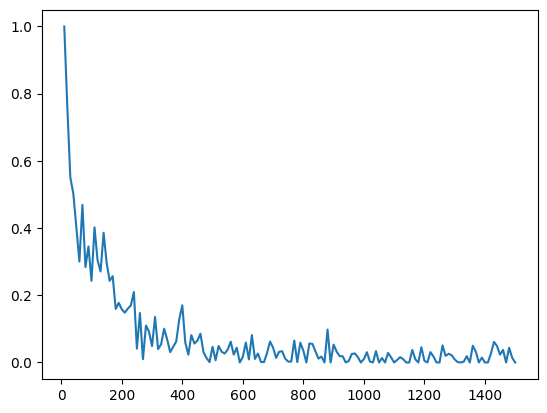

In [13]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(150):

    # Iterate over batches
    for i, (anchor, positive, negative, _) in enumerate(train_dataloader):

        # Send the images and labels to CUDA
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output_anchor, output_positive, output_negative = net(anchor, positive, negative)

        # Pass the outputs of the networks and label into the loss function
        loss_triplet = criterion(output_anchor, output_positive, output_negative)

        # Calculate the backpropagation
        loss_triplet.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_triplet.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_triplet.item())

show_plot(counter, loss_history)

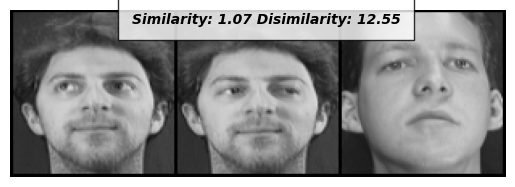

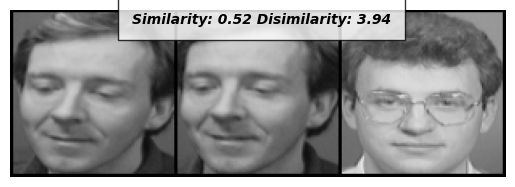

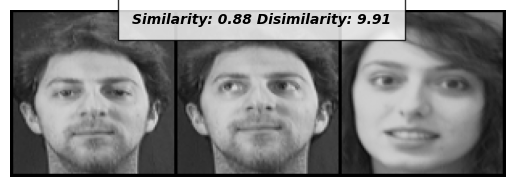

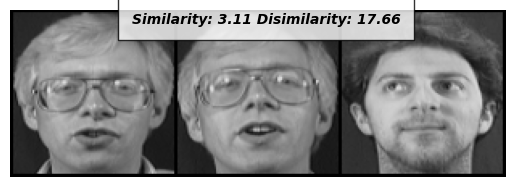

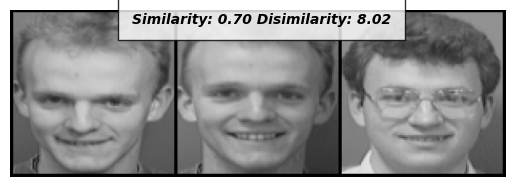

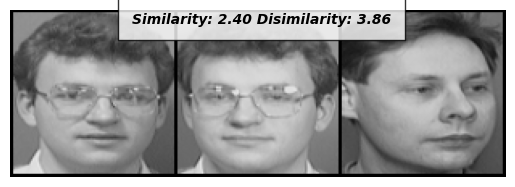

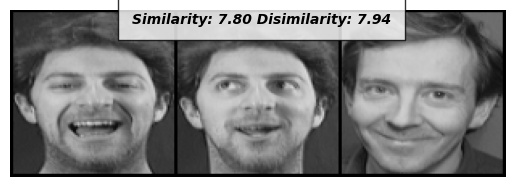

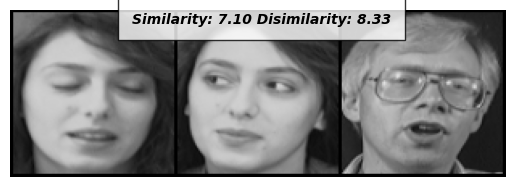

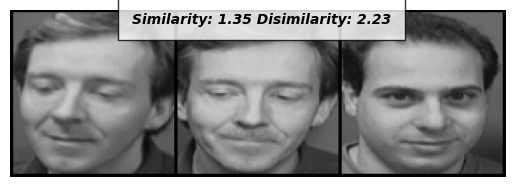

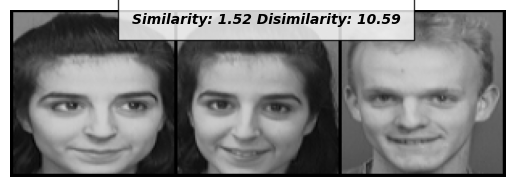

In [14]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
anchor, positive, negative, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative = net(anchor.to(device), positive.to(device), negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Similarity: {euclidean_distance_positive.item():.2f} Disimilarity: {euclidean_distance_negative.item():.2f}')

Save Parameters


In [15]:
#torch.save({"model_state_dict": net.state_dict(),"optimizer_state_dict": optimizer.state_dict()}, "trained_model.pth")

Visualization of trained network

In [51]:
train_results = []
labels = []
net.eval()
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation,rand=False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=11)

# Extract one batch
anchor, _, _, label = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images

with torch.no_grad():
    for i in range(5):
        output_anchor = net.forward_once(anchor.to(device))
        train_results.append(output_anchor.cpu().numpy())
        labels.append(label[0][0])
        anchor, _, _, label = next(iter(vis_dataloader))
train_results = np.concatenate(train_results)


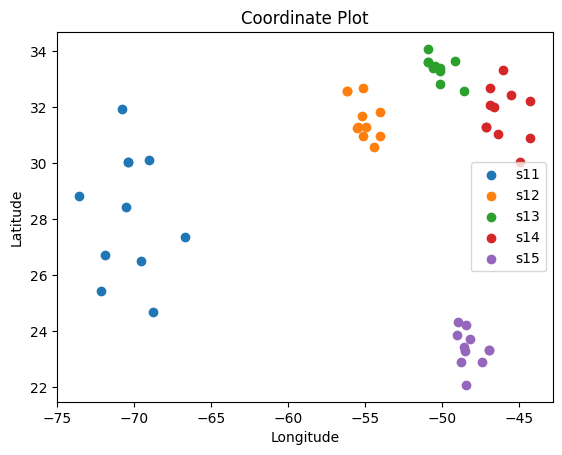

In [52]:
for i, label in enumerate(labels):
    label_coordinates = train_results[i*11:(i+1)*11]
    latitudes = [coord[0] for coord in label_coordinates]
    longitudes = [coord[1] for coord in label_coordinates]
    plt.scatter(longitudes, latitudes, label=label)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinate Plot')
plt.legend()
plt.show()

In [55]:
print(train_results[11:22])
print(labels[2])

[[ 24.685472 -68.74838 ]
 [ 25.447794 -72.14424 ]
 [ 27.377745 -66.70332 ]
 [ 26.490797 -69.54848 ]
 [ 30.112406 -69.05792 ]
 [ 31.927612 -70.7702  ]
 [ 26.71308  -71.88959 ]
 [ 28.81432  -73.543205]
 [ 28.421165 -70.5475  ]
 [ 30.061552 -70.38547 ]
 [ 30.061552 -70.38547 ]]
s14
